## 1) Do paid apps actually have higher ratings than free apps?
### - Tests whether price signals quality and informs pricing decisions for developers
## 2) Do larger apps receive lower ratings due to storage concerns?
## 3) How do ratings vary across different content rating groups?
### - Reveals whether targeting different audiences impacts perceived quality.
## 4) Do recently updated apps have better ratings?
### - Connects developer maintenance effort to user satisfaction and time-based relevance.
## 5) Do saturated categories suffer from lower average ratings?
### - Uncovers competitive pressure effects and category-level quality dilution.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
%matplotlib inline

In [2]:
google = pd.read_csv('googleplaystore.csv')

### Data Cleaning and EDA

In [3]:
print(google.dtypes)
google.head()

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
for col in google.columns:
    print(f'{col}: {google[col].unique()}')

App: ['Photo Editor & Candy Camera & Grid & ScrapBook' 'Coloring book moana'
 'U Launcher Lite – FREE Live Cool Themes, Hide Apps' ...
 'Parkinson Exercices FR' 'The SCP Foundation DB fr nn5n'
 'iHoroscope - 2018 Daily Horoscope & Astrology']
Category: ['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION' '1.9']
Rating: [ 4.1  3.9  4.7  4.5  4.3  4.4  3.8  4.2  4.6  3.2  4.   nan  4.8  4.9
  3.6  3.7  3.3  3.4  3.5  3.1  5.   2.6  3.   1.9  2.5  2.8  2.7  1.
  2.9  2.3  2.2  1.7  2.   1.8  2.4  1.6  2.1  1.4  1.5  1.2 19. ]
Reviews: ['159' '967' '87510' ... '603' '1195' '398307']
Si

#### Dropping unnecessary columns and converting columns to correct data types

In [5]:
# Dropping unnecessary 'Size' values not helpful for analysis
google = google[google['Size'] != 'Varies with device']
google = google[google['Size'] != '1,000+']

# Dropping unnecessary columns not useful for analysis to reduce clutter and improve clarity
google = google.drop(columns=['Installs', 'Current Ver', 'Android Ver', 'Genres'])


def parse_size(value: str) -> int:
    if pd.isna(value):
        return np.nan

    value = value.strip()

    if value.endswith('M'):
        return int(float(value[:-1]) * 1_000_000)

    if value.endswith('k'):
        return int(float(value[:-1]) * 1_000)

    return int(float(value))
# Turning 'Price' into in float data type whilst removing '$'
google['Price'] = google['Price'].str.replace('$', '', regex=False).astype(float)

# Turning 'Size' into integer data type
google['Size'] = google['Size'].apply(parse_size).astype(int)

# Turning 'Reviews' column into integer data type
google['Reviews'] = google['Reviews'].astype(int)

# Turning 'Last Updated' into a datetime data type, truncating for just the year, then converting to integer
google['Last Updated'] = pd.to_datetime(google['Last Updated']).dt.to_period('Y')
current_year = pd.Timestamp.now().year
google['Years since last update'] = (current_year - google['Last Updated'].dt.year).astype(int)

# Dropping 'Last Updated' column as we now have a more useful column for analysis
google = google.drop(columns=['Last Updated'])

# Renaming columns
google.rename(columns={'Size': 'Size (bites)', 'Price': 'Price ($)', 'Reviews': 'No. of reviews'}, inplace=True)

In [6]:
google.head()

,App,Category,Rating,No. of reviews,Size (bites),Type,Price ($),Content Rating,Years since last update
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000,Free,0.0,Everyone,7
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000,Free,0.0,Everyone,7
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000,Free,0.0,Everyone,7
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000,Free,0.0,Teen,7
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000,Free,0.0,Everyone,7


In [7]:
google.dtypes

App                         object
Category                    object
Rating                     float64
No. of reviews               int64
Size (bites)                 int64
Type                        object
Price ($)                  float64
Content Rating              object
Years since last update      int64
dtype: object

#### Dealing will null/missing rows

In [8]:
google.isna().sum()

App                           0
Category                      0
Rating                     1416
No. of reviews                0
Size (bites)                  0
Type                          0
Price ($)                     0
Content Rating                0
Years since last update       0
dtype: int64

In [9]:
# Dropping null rows as the dataset is vast and should not affect analysis significantly
google = google.dropna()
google.isna().sum()

App                        0
Category                   0
Rating                     0
No. of reviews             0
Size (bites)               0
Type                       0
Price ($)                  0
Content Rating             0
Years since last update    0
dtype: int64

In [10]:
google.head()

,App,Category,Rating,No. of reviews,Size (bites),Type,Price ($),Content Rating,Years since last update
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000,Free,0.0,Everyone,7
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000,Free,0.0,Everyone,7
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000,Free,0.0,Everyone,7
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000,Free,0.0,Teen,7
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000,Free,0.0,Everyone,7


## 1) Do paid apps actually have higher ratings than free apps?

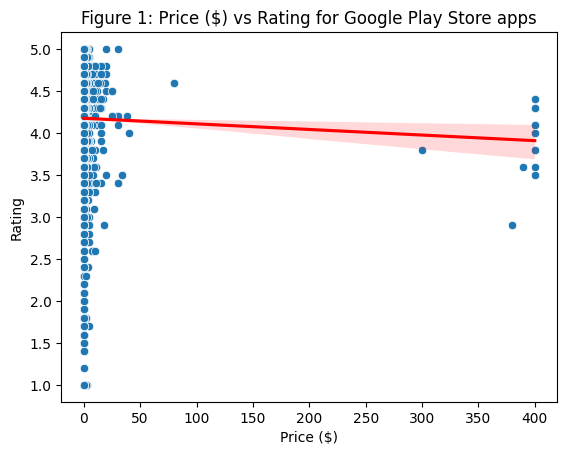

<Figure size 640x480 with 0 Axes>

In [11]:
sns.scatterplot(
    data=google,
    x='Price ($)',
    y='Rating',
)

sns.regplot(
    data=google,
    x='Price ($)',
    y='Rating',
    scatter=False,
    color='red'
)

plt.title('Figure 1: Price ($) vs Rating for Google Play Store apps')
plt.show()
plt.clf()

# Pearson correlation test
# r, p = stats.pearsonr(google['Price ($)'].values, google['Rating'].values)
# print(f'Pearson r-value: {r}')
# print(f'Pearson p-value: {p}')

Due to an enormous amount of data points have price values of $0, to stop the results from becoming too zero-inflated skewed, it has been decided to emit all free apps from further analysis for this question.

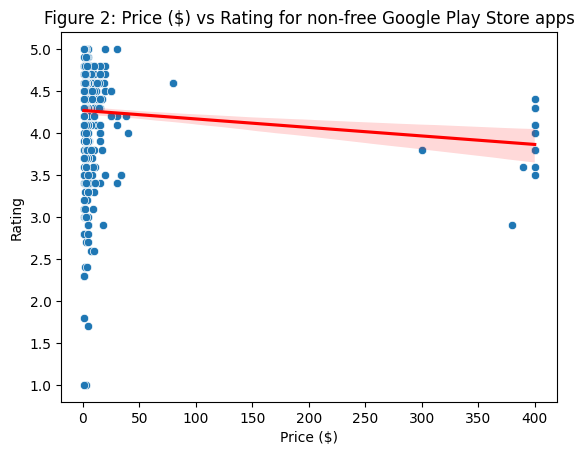

Spearman ρ = -0.088, p-value = 0.0348


<Figure size 640x480 with 0 Axes>

In [12]:
paid = google[google['Price ($)'] > 0]

sns.scatterplot(
    data=paid,
    x='Price ($)',
    y='Rating',
)

sns.regplot(
    data=paid,
    x='Price ($)',
    y='Rating',
    scatter=False,
    color='red'
)

plt.title('Figure 2: Price ($) vs Rating for non-free Google Play Store apps')
plt.show()
plt.clf()

rho_paid, p_paid = spearmanr(paid['Price ($)'], paid['Rating'])
print(f'Spearman ρ = {rho_paid:.3f}, p-value = {p_paid:.3g}')

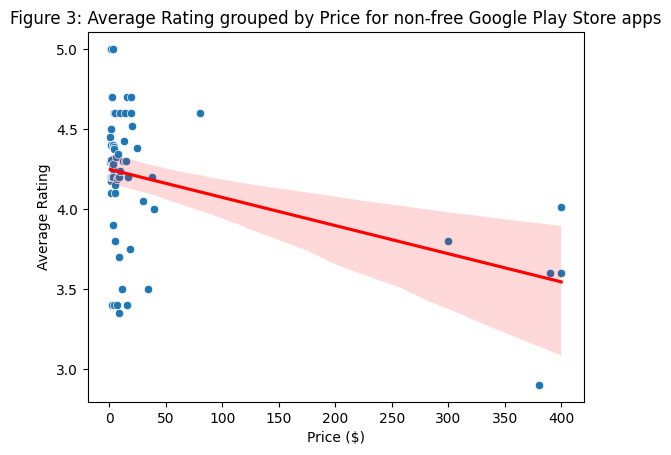

Spearman ρ = -0.226, p-value = 0.0664


<Figure size 640x480 with 0 Axes>

In [13]:
avg_rating_by_price = (paid.groupby('Price ($)')['Rating'].mean().reset_index())
avg_rating_by_price.rename(columns={'Rating': 'Average Rating'}, inplace=True)

sns.scatterplot(
    data=avg_rating_by_price,
    x='Price ($)',
    y='Average Rating',
)

sns.regplot(
    data=avg_rating_by_price,
    x='Price ($)',
    y='Average Rating',
    scatter=False,
    color='red'
)

plt.title('Figure 3: Average Rating grouped by Price for non-free Google Play Store apps')
plt.show()
plt.clf()

# r, p = stats.pearsonr(avg_rating_by_price['Price ($)'].values, avg_rating_by_price['Average Rating'].values)
# print(f'Pearson r-value: {r}')
# print(f'Pearson p-value: {p}')

rho, p = spearmanr(avg_rating_by_price['Price ($)'], avg_rating_by_price['Average Rating'])
print(f'Spearman ρ = {rho:.3f}, p-value = {p:.3g}')

It is clear that there are also some extreme values of apps with prices of $300+ distorting the results, so it would be wise to redo this analysis without those values to investigate any potential differnce.

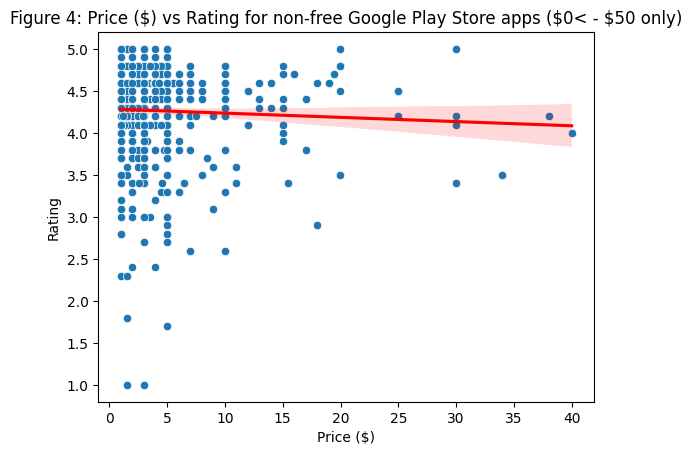

Spearman ρ = -0.052, p-value = 0.221


<Figure size 640x480 with 0 Axes>

In [14]:
better_prices = paid[paid['Price ($)'] < 50]

sns.scatterplot(
    data=better_prices,
    x='Price ($)',
    y='Rating',
)

sns.regplot(
    data=better_prices,
    x='Price ($)',
    y='Rating',
    scatter=False,
    color='red'
)

plt.title('Figure 4: Price ($) vs Rating for non-free Google Play Store apps ($0< - $50 only)')
plt.show()
plt.clf()

# r, p = stats.pearsonr(better_prices['Price ($)'].values, better_prices['Rating'].values)
# print(f'Pearson r-value: {r}')
# print(f'Pearson p-value: {p}')

rho, p = spearmanr(better_prices['Price ($)'], better_prices['Rating'])
print(f'Spearman ρ = {rho:.3f}, p-value = {p:.3g}')

<>:18: SyntaxWarning: invalid escape sequence '\$'
<>:18: SyntaxWarning: invalid escape sequence '\$'
C:\Users\sammy\AppData\Local\Temp\ipykernel_19528\3861440775.py:18: SyntaxWarning: invalid escape sequence '\$'
  plt.title('Figure 5: Average Rating grouped by Price for non-free Google Play Store apps (\$0< - \$50 only)')


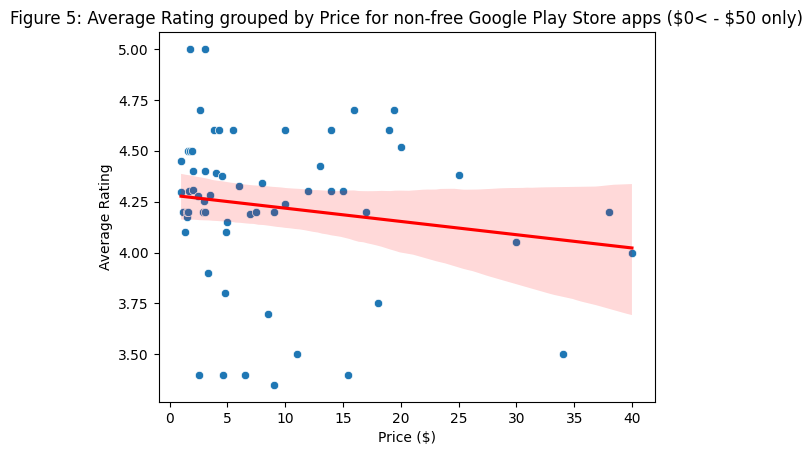

Spearman ρ = -0.110, p-value = 0.4


<Figure size 640x480 with 0 Axes>

In [15]:
avg_rating_by_better_price = (better_prices.groupby('Price ($)')['Rating'].mean().reset_index())
avg_rating_by_better_price.rename(columns={'Rating': 'Average Rating'}, inplace=True)

sns.scatterplot(
    data=avg_rating_by_better_price,
    x='Price ($)',
    y='Average Rating',
)

sns.regplot(
    data=avg_rating_by_better_price,
    x='Price ($)',
    y='Average Rating',
    scatter=False,
    color='red'
)

plt.title('Figure 5: Average Rating grouped by Price for non-free Google Play Store apps (\$0< - \$50 only)')
plt.show()
plt.clf()

# r, p = stats.pearsonr(avg_rating_by_better_price['Price ($)'].values, avg_rating_by_better_price['Average Rating'].values)
# print(f'Pearson r-value: {r}')
# print(f'Pearson p-value: {p}')

rho, p = spearmanr(avg_rating_by_better_price['Price ($)'], avg_rating_by_better_price['Average Rating'])
print(f'Spearman ρ = {rho:.3f}, p-value = {p:.3g}')

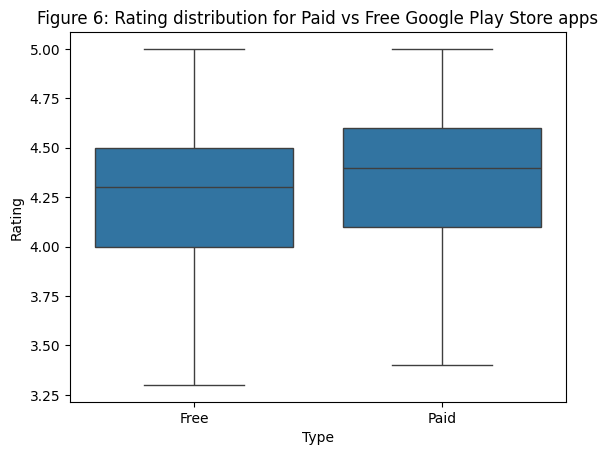

<Figure size 640x480 with 0 Axes>

In [16]:
sns.boxplot(data=google, x='Type', y='Rating', showfliers=False)
plt.title('Figure 6: Rating distribution for Paid vs Free Google Play Store apps')
plt.show()
plt.clf()

The results here were somewhat inconclusive; Figure 6 shows that the overall distribution of paid apps' ratings is higher than that of free ones. However, whilst Figures 2-5 all appeared to show a negative correlation between price and rating, Spearman rank showed that only Figure 1, price vs rating across the entire non-zero price range, had a significant correlation (`p = 0.348`); accounting for extreme price values (only including apps price above 0 but below 50 dollars) did not yield a more significant correlation, visually or statistically.

## 2) Do larger apps receive lower ratings due to storage concerns?

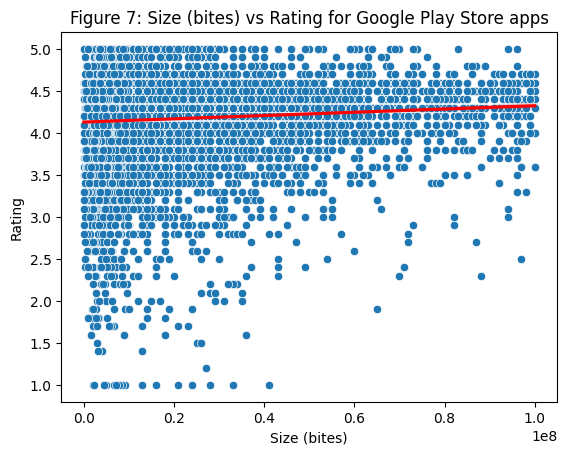

Spearman ρ = 0.069, p-value = 1.03e-09


<Figure size 640x480 with 0 Axes>

In [17]:
sns.scatterplot(
    data=google,
    x='Size (bites)',
    y='Rating',
)

sns.regplot(
    data=google,
    x='Size (bites)',
    y='Rating',
    scatter=False,
    color='red'
)

plt.title('Figure 7: Size (bites) vs Rating for Google Play Store apps')
plt.show()
plt.clf()

# r, p = stats.pearsonr(google['Size (bites)'].values, google['Rating'].values)
# print(f'Pearson r-value: {r}')
# print(f'Pearson p-value: {p}')

rho, p = spearmanr(google['Size (bites)'], google['Rating'])
print(f'Spearman ρ = {rho:.3f}, p-value = {p:.3g}')

Despite being a very weak correlation in magnitude, with a `ρ` value of only `0.069`, and there being almost no discernible pattern between size and rating in Figure 6, the Spearman rank correlation test still computes a significant correlation between the two variables, with a `p` value of `1.03 x 10^-9`. 

## 3) How do ratings vary across different content rating groups?

In [18]:
google['Content Rating'].value_counts()

Content Rating
Everyone           6172
Teen                868
Mature 17+          368
Everyone 10+        318
Adults only 18+       2
Unrated               1
Name: count, dtype: int64

In [19]:
google['Content Rating'].value_counts(normalize=True)

Content Rating
Everyone           0.798551
Teen               0.112304
Mature 17+         0.047613
Everyone 10+       0.041144
Adults only 18+    0.000259
Unrated            0.000129
Name: proportion, dtype: float64

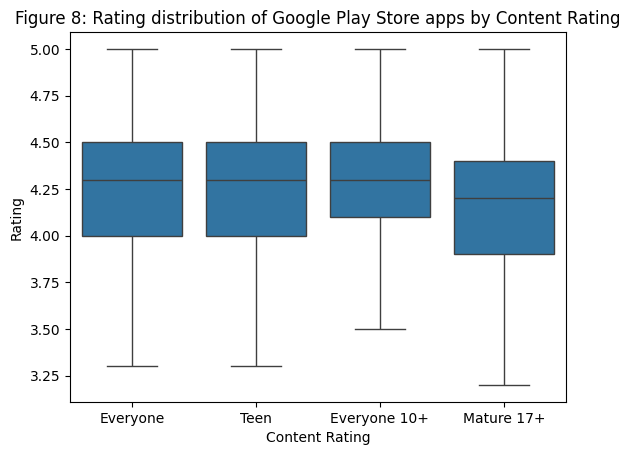

F-statistic: 8.428
p-value: 0.00001
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
    Everyone Everyone 10+   0.0946 0.0134  0.0142  0.1749   True
    Everyone   Mature 17+  -0.0711 0.0707 -0.1461  0.0039  False
    Everyone         Teen   0.0606 0.0113    0.01  0.1113   True
Everyone 10+   Mature 17+  -0.1656 0.0004 -0.2726 -0.0586   True
Everyone 10+         Teen  -0.0339 0.7767 -0.1255  0.0577  False
  Mature 17+         Teen   0.1317 0.0006  0.0448  0.2186   True
----------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [20]:
# Removing rows of 'Content Rating = Adults only 18+' and 'Unrated' due to low proportions
google = google[google['Content Rating'] != 'Adults only 18+']
google = google[google['Content Rating'] != 'Unrated']

sns.boxplot(data=google, x='Content Rating', y='Rating', showfliers=False)
plt.title('Figure 8: Rating distribution of Google Play Store apps by Content Rating')
plt.show()
plt.clf()

# One-way ANOVA test to see if 'Rating' significantly differs between 'Content Rating' group
groups = [google.loc[google['Content Rating'] == rating, 'Rating'] for rating in google['Content Rating'].unique()]

f_stat, p_value = f_oneway(*groups)

print(f'F-statistic: {f_stat:.3f}')
print(f'p-value: {p_value:.5f}')

# Tukey pairwase test to see which 'Content Rating' group differs the most
tukey = pairwise_tukeyhsd(endog=google['Rating'], groups=google['Content Rating'], alpha=0.05)
print(tukey)

Looking at Figure 7, it does not appear at first glance that there is a significant difference between the ratings for different content rating groups, aside from 'Mature 17+', which appears to rank lower than the other 3 categories. However, by using ANOVA, we can see that is actually a significant difference given by the p-value of 0.00001, and Tukey's test tells us that there is a significant difference between each content rating category (except for between 'Everyone' and 'Mature 17+', and 'Everyone 10+' and 'Teen'), with the most significant differences being that of pairs including 'Mature 17+', which is to be expected as it is the most visually significantly different group when looking at Figure 7. Interestingly, Tukey's test reveals that there is a significant difference for rating between 'Everyone' and 'Teen', despite their distributions looking nearly identical to one another in Figure 7. 

## 4) Do recently updated apps have better ratings?

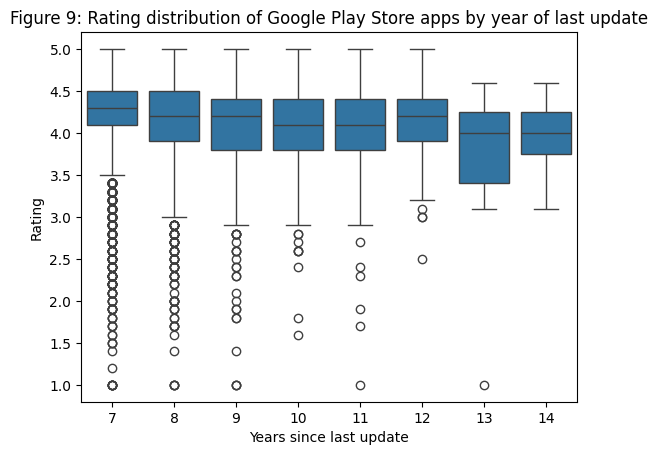

Spearman ρ = -0.171, p-value = 1.41e-51


<Figure size 640x480 with 0 Axes>

In [21]:
# Dropping these values as there is only one row of it, so make analysis easier
google = google[google['Years since last update'] != 15]

sns.boxplot(data=google, x='Years since last update', y='Rating', showfliers=True)
plt.title('Figure 9: Rating distribution of Google Play Store apps by year of last update')
plt.show()
plt.clf()

rho, p = spearmanr(google['Years since last update'], google['Rating'])
print(f'Spearman ρ = {rho:.3f}, p-value = {p:.3g}')

Looking at Figure 8, there does appear to be a downward overall trend between years since last update and an app's rating, suggesting that more frequently updated apps do tend to rate higher than older, more 'forgotten about' ones. The Spearman rank backs up Figure 8's findings, that there is a very significant (p = 1.41x10^-51), albeit weak (ρ = -0.171), negative correlation between the years elapsed since a app received an update and the rating a user gives it.

## 5) Do saturated categories suffer from lower average ratings?

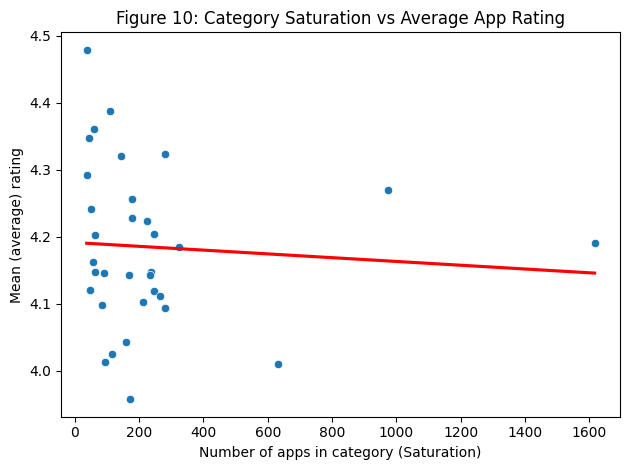

Spearman ρ = -0.259, p-value = 0.145


<Figure size 640x480 with 0 Axes>

In [22]:
category_stats = (google.groupby('Category').agg(app_count=('App', 'count'), mean_rating=('Rating', 'mean')).reset_index())
sns.scatterplot(data=category_stats, x='app_count', y='mean_rating')
sns.regplot(data=category_stats, x='app_count', y='mean_rating', scatter=False, ci=None, color='red')
plt.xlabel('Number of apps in category (Saturation)')
plt.ylabel('Mean (average) rating')
plt.title('Figure 10: Category Saturation vs Average App Rating')
plt.tight_layout()
plt.show()
plt.clf()

rho, p = spearmanr(category_stats['app_count'], category_stats['mean_rating'])
print(f'Spearman ρ = {rho:.3f}, p-value = {p:.3g}')

Looking at Figure 10, whilst it shows a negative regression line suggesting that more apps there are in a category the lower that app receives in rating on average, its Spearman Rank test shows that this relationship is not significant.

## Conclusion

These results suggest that while several variables are indeed statistically associated with app rating on the Google Play Store, their practical impact is generally modest, and strong effects don't appear to be common. Monetisation shows the least significant influence: although paid apps show a higher overall rating distribution than free apps, the relationship between price and rating is predominantly statistically insignificant once realistic price boundaries are considered. This suggests that a more expensive app does not necessarily lead to users ranking it higher. Similarly, whilst app storage size shows a statistically significant with its user rating, this effect is very small, indicating that storage concerns play only a negligible role in shaping individual user ratings.

Variables such as content targeting and maintenance behaviour towards and app show more meaningful patterns. Ratings differ significantly across content rating groups, with statistical testing revealing distinctions not immediately obvious from the data visualisations, bring attention to the importance of statistical testing alongside exploratory visual plots. Specifically, apps rated 'Mature 17+' consistently differ from other content rating groups, implying that audience or content expectations may meaningfully influence user evaluations. Update frequency also demonstrates a clear and statistically robust relationship with ratings: apps that have been updated more recently tend to receive higher ratings, supporting the idea that an app that is regularly maintained and stays relevant positively contributes to user satisfaction, even if the magnitude of this effect is small.

Finally, how competitive an app category is does not appear to significantly lower average app quality. Whilst visually speaking it would appear that more saturated categories receive lower average app ratings, these findings are statistically insignificant, indicating that increased competition alone doesn't necessarily lead to worse user experience.

Overall, findings suggest that user ratings are influenced more by qualitative factors such as active maintenance rather than price, size, or market saturation, and that statistically significant effects in large datasets should be interpreted cautiously with respect to their real-world importance.